# Exponential Smoothing (Holt-Winter's Method)

With seasonality and trend identified in our data, we need to be conscious of choosing time series models that can handle trend and seasonality so that these patterns are reflected in our models' forecasts. Exponential Smoothing and ARIMA models are two of the most widely used types of time series models that we will also use for our modeling purposes. They both can handle seasonality and trend in data and provide for very accurate forecasts, although the models work in notably different ways. 

Before we begin, lets reload the data (since data loaded into one Jupyter notebook is not available in the next notebook):

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SARIMAX

bike = pd.read_csv('./data/rides_monthly_aggregate.csv', usecols = [1])
bike.set_index(pd.period_range('1/1/2013', freq='M', periods=84), inplace = True)

We'll first try Holt-Winter's method for modeling out data. Exponential Smoothing methods essentially use weighted averages of the observed data in order to fit a model that can accurate model the patterns found in the data, where the weights exponentially decrease for observations that are further in the past. Additional component (essentially equations) are added to the model to capture trend and seasonality within the data.

We use Holt-Winter's method with both additive trend and seasonality along with dampening to model the data. We then set _seasonal_periods_ to be 12 in order to capture the monthly seasonality that occurs every year. We fit the model and plot the model's fitted values over the true data in the following:

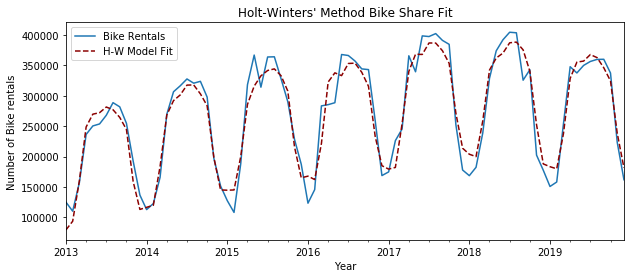

In [3]:
fit_hw = ExponentialSmoothing(bike, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit()

bike_plot = bike.plot(figsize=(10,4), title="Holt-Winters' Method Bike Share Fit")
bike_plot.set_ylabel("Number of Bike rentals")
bike_plot.set_xlabel("Year")

fit_hw.fittedvalues.plot(ax=bike_plot, style='--', color='DarkRed')
bike_plot.legend(['Bike Rentals', 'H-W Model Fit']);

In [4]:
# The MAPE (Mean Average Percentage Error) of the H-W model
np.average(np.absolute((fit_hw.fittedvalues - bike['num_rides']) / bike['num_rides']))

0.08627115348980559

<br>

Our model does seem to capture the seasonality and overall increasing trend well- even capturing the slight tapering off and decrease within year 2019. 

As a good measure of how well the model fits the data, we take a look at the Mean Average Percentage Error (MAPE) of the model, which provides how "off" our model's fitted values are from the true data in percentage. Given above, our model's fitted values are off by an average of 8.6% of the true observations, which is pretty accurate. We could use the MAPE for model selection if we had a number of models to compare each other against in order to select the optimal model, but since we only have one model, the MAPE value is useful for seeing how well our model fits the data. The low MAPE value gives us confidence that our model fits the data well and is capturing information that will generate useful forecasts.

<br>

## Model Diagnostics

Before proceeding with using our model for forecasting purposes, we ran diagnostic measures to ensure that our model fit is strong as well as check to see if there is any additional information left in the residuals/errors that we can further extract to improve the model. 

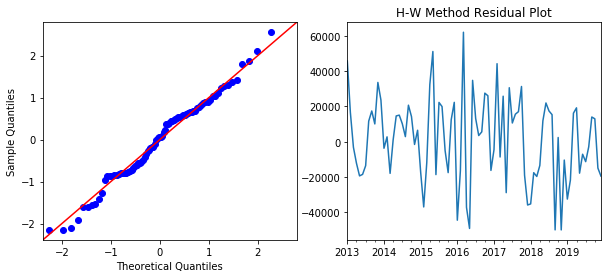

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Using the 
fig = sm.qqplot(fit_hw.resid, line='45', fit=True, ax=axes[0])
fig = fit_hw.resid.plot(title="H-W Method Residual Plot", ax=axes[1]);

<br>

For diagnosing our model and checking model assumptions, we utilized a quantile-quantile (QQ) plot and a time plot of the residuals. On the left, we have the QQ plot with a normal distribution plotted on the diagonal. The observations follow the diagonal closely, albeit with some fluctuations from strict normal distribution towards the tails, so we can conclude that it is reasonable to assume the residuals are of normal distribution. On the right, we have a time plot of the residuals. There are no obvious visual patterns or behavior in this plot, so we conclude that the residuals are not correlated and that most of the information in our data has been extracted for model fitting.

<br>

## Model Inferences

With these two things checked, we conclude that our model is well-fitted to the data and we can proceed to take a look at the fitted model itself to gain some insight into the data we have. For this purpose, we can call on the fitted model's _summary_ method:

In [6]:
# Get summary printout of H-W model fit
print(fit_hw.summary())

ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                   84
Model:             ExponentialSmoothing   SSE                    47735873716.674
Optimized:                         True   AIC                           1727.283
Trend:                         Additive   BIC                           1768.607
Seasonal:                      Additive   AICC                          1739.158
Seasonal Periods:                    12   Date:                 Tue, 21 Apr 2020
Box-Cox:                          False   Time:                         19:18:29
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2119787                alpha                 True
smoothing_slope              7.5442e-09         

<br>

Our exponential smoothing model allows for some inference into the trend and seasonality of our bike rental data through the estimated values of the level, slope, and seasonal smoothing parameters. For example, note that the _smoothing seasonal_ (gamma) coefficient was estimated to be _0_. This implies that there is no variation in the seasonal effect on bike rentals from year to year- the general pattern of a rise and fall in ridership within each calendar year stays consistent throughout each of the years. This is could be due to users of the bike sharing service who rely on bike sharing as a reliable method for commuting to work throughout the Washington DC metro area- it would make sense that traffic from these particular users ebb and flow with consistency throughout the years, as work schedules are reasonably robust.

<br>

## Forecasting

Beyond just insight into the data, however, we are also interested in predicting ridership numbers over the next few months or years. We can use the fitted model's _forecast_ method in order to do some forecasting to predict the number of bike rentals that we are likely to see in the following year: 


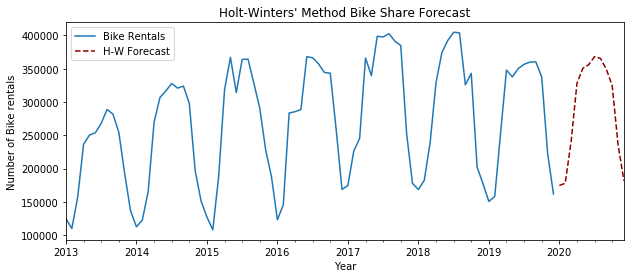

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))
fig = bike['num_rides'].plot(ax=ax, title="Holt-Winters' Method Bike Share Forecast")
fig.set_ylabel("Number of Bike rentals")
fig.set_xlabel("Year")
fit_hw.forecast(12).plot(ax = ax,style = '--', color = 'DarkRed')
fig.legend(['Bike Rentals', 'H-W Forecast']);

<br>

The Holt-Winters' method predicts the 2020 year to have monthly average riderships that reflect pretty much the same seasonal pattern and average that we've seen in prior years. It is also worth nothing that the forecasted bike rental numbers for 2020 reflect a lowered ridership count that follows the downward trend that occured from 2018 to the end of 2019. Note that there forecasts come with no associated prediction intervals when using the Holt-Winters' method since it technically is not a statistical model, so our forecasted values are only point forecasts. _statsmodels_ does have an equivalent statespace model to the Holt-Winters' method that allows for accompanying prediction intervals for the forecasts, so if you are interested, you can check them out here: [link](https://www.statsmodels.org/stable/statespace.html#linear-exponential-smoothing-models).

In particular, the predicted monthly bike rental numbers for 2020 are given in the following output. Note that the numbers returned are decimal values representing the forecasted mean number of rentals at each month (otherwise it wouldn't make sense to predict that we'll have a fraction of a rental).

In [8]:
fit_hw.forecast(12)

2020-01    174730.700724
2020-02    178107.232711
2020-03    240402.581126
2020-04    328052.273252
2020-05    350640.580571
2020-06    356054.444794
2020-07    368189.065083
2020-08    365507.146899
2020-09    349329.192789
2020-10    324623.206408
2020-11    235689.084023
2020-12    181698.275617
Freq: M, dtype: float64

<br>

[Previous](https://github.com/Christopher-Liu/bikeshare-ts-analysis/blob/master/1-Data_Aggregation_and_EDA.ipynb) | [Next](https://github.com/Christopher-Liu/bikeshare-ts-analysis/blob/master/3-Modeling_Seasonal_ARIMA.ipynb)

1. [Data Aggregation and EDA](https://github.com/Christopher-Liu/bikeshare-ts-analysis/blob/master/1-Data_Aggregation_and_EDA.ipynb)

2. [__Modeling: Holt-Winters' Method__](https://github.com/Christopher-Liu/bikeshare-ts-analysis/blob/master/2-Modeling_Holt-Winters_Method.ipynb)

3. [Modeling: Seasonal ARIMA](https://github.com/Christopher-Liu/bikeshare-ts-analysis/blob/master/3-Modeling_Seasonal_ARIMA.ipynb)
